# Bank marketing use case | Root Cause Analysis
## 0. Setup

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pickle
from utils import model_performance

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
model = pickle.load(open('../models/model_log.cav','rb'))

## 1. Introduction

This exercise will teach you how you can use the documentation generated by the log files to determine a root cause of your issue and add post-mortem monitoring rules to avoid the same issue to appear.

In june, the marketing team reported to your team that june's campaign was a flop because of a lack of prospect to be contacted. June’s campaign has a perfect precision of `70%`, but only `$440` were generated.   

By opening the report, you don't see any major issue at first sight.

You decide to come back to the pipeline to analyse it further. 

## 2. Pipeline

Replay the full pipeline to evaluate the performance.

In [5]:
#Extraction
customers_info = pd.read_csv('../data/predict/jun-customers-data.csv')
contact_info = pd.read_csv('../data/predict/jun-contact-data.csv')
business_info = pd.read_csv('../data/predict/jun-business-data.csv')
customer360 = customers_info.merge(contact_info,on='id')
jun = pd.merge(customer360,business_info)

In [6]:
#Preparation
jun['education']=np.where(jun['education'] =='basic.9y', 'Basic', jun['education'])
jun['education']=np.where(jun['education'] =='basic.6y', 'Basic', jun['education'])
jun['education']=np.where(jun['education'] =='basic.4y', 'Basic', jun['education'])

cat = [i for i in ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'] if i in jun.columns]

data_dummy = pd.get_dummies(jun,columns=cat)

features=[i for i in ['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 
  'month_apr', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 
  'month_may', 'month_nov', 'month_oct', "poutcome_success"] if i in data_dummy.columns]

jun_final = data_dummy[features]



In [7]:
#Prediction
predictions = model.predict(jun_final)
jun_final['id'] = jun['id']
jun_final['prediction']=predictions
model_performance(jun_final,'jun')

The precision of the model in jun was of 0.7
This results in a profit of $440


In [8]:
jun_final.to_csv('../data/predict/jun-predicted.csv',index=False)

## 3. Definition of the issue 

As the marketing team said, there is a lack of prospect to be contacted, however the size of the database (number of prospects on which the model has been performed) is quite aligned with what we had for the previous months. 

**Exercise:** From the `jun-predicted.csv` dataset (available as `jun_final`), extract the number of prospects the team has sent to the marketing team (customers with 1 in the prediction column) and compare this to the situation in january `jan-predicted.csv`. 

In [9]:
#Solution
jan = pd.read_csv('../data/predict/jan-predicted.csv')

count_january = sum(jan.prediction)
count_june = sum(jun_final.prediction)

print('The number of prospects sent to the marketing team was %s in january and %s in june'%(count_january,count_june))

The number of prospects sent to the marketing team was 191 in january and 10 in june


Now that you've detected the issue, you can set a new SLO to prevent the same situation in the future. 

## 4. Cause of the issue

Back to the monitoring file, you can see that the `eurolibor3m` has been set to `3` by default in the dataset. This issue was not detected with the current monitoring rules. A new rule on the `standard deviation` for instance can prevent the issue. 

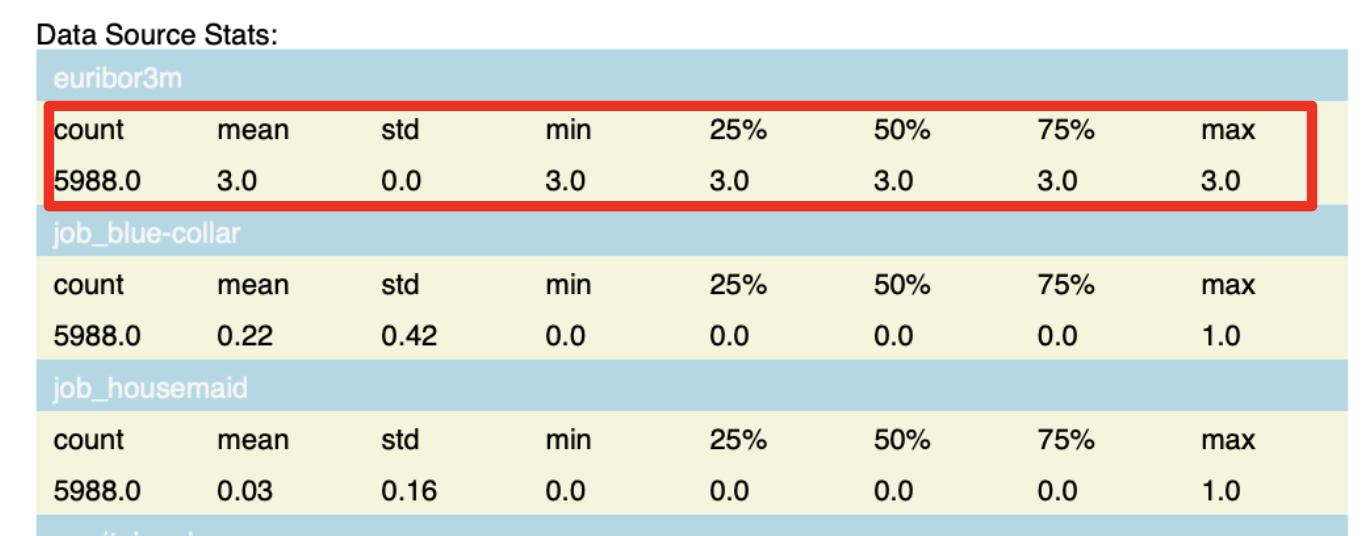




## Congratulations!

Congrats! You've just completed the journey on the essentials of AI observability. We hope you had a great time doing this!